In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cargar los datos
images = np.load("/content/drive/MyDrive/DeepLearning/images_final.npy")
data = pd.read_csv("/content/drive/MyDrive/DeepLearning/filtered_data_final.csv", sep=';')


In [5]:
# Asegurarse de que las imágenes y los datos estén alineados
print (images.shape)
print (data.shape)

(3131, 224, 224, 3)
(3131, 72)


In [6]:
# Dividir los datos en train, validation y test
X_train_val, X_test, data_train_val, data_test = train_test_split(
    images, data, test_size=0.2, random_state=42)

X_train, X_val, data_train, data_val = train_test_split(
    X_train_val, data_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.12

del images, data
gc.collect()


0


Distribución para el Conjunto de Entrenamiento:
price_range
0    639
1    619
2    620
Name: count, dtype: int64

Porcentajes:
price_range
0    34.025559
1    32.960596
2    33.013845
Name: proportion, dtype: float64


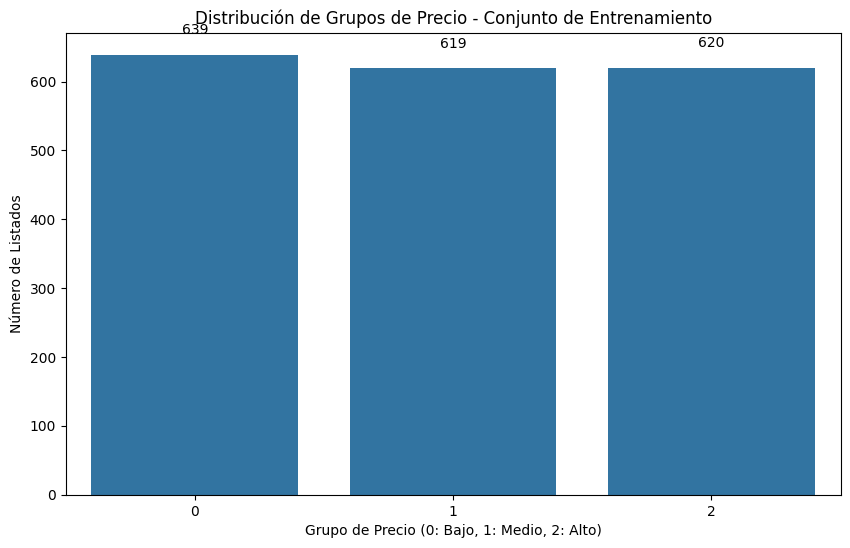


Rangos de precios por categoría - Conjunto de Entrenamiento:
               min      max
price_range                
0             20.0     88.0
1             89.0    163.0
2            164.0  10000.0


In [8]:
q34, q67 = np.percentile(data_train['price'], [34, 67])

def create_price_range(price):
    if price < q34:
        return 0  # Bajo
    elif q34 <= price < q67:
        return 1  # Medio
    else:
        return 2  # Alto

# Aplicar la función de rangos a cada conjunto por separado
data_train['price_range'] = data_train['price'].apply(create_price_range)
data_val['price_range'] = data_val['price'].apply(create_price_range)
data_test['price_range'] = data_test['price'].apply(create_price_range)

# Mostrar distribución solo para el conjunto de entrenamiento
print("\nDistribución para el Conjunto de Entrenamiento:")
print(data_train['price_range'].value_counts().sort_index())
print("\nPorcentajes:")
print(data_train['price_range'].value_counts(normalize=True).sort_index() * 100)

plt.figure(figsize=(10, 6))
sns.countplot(x='price_range', data=data_train, order=[0, 1, 2])
plt.title('Distribución de Grupos de Precio - Conjunto de Entrenamiento')
plt.xlabel('Grupo de Precio (0: Bajo, 1: Medio, 2: Alto)')
plt.ylabel('Número de Listados')

for i, v in enumerate(data_train['price_range'].value_counts().sort_index()):
    plt.text(i, v + 30, str(v), ha='center')
plt.show()

# Mostrar los rangos de precios para cada categoría solo en el conjunto de entrenamiento
print("\nRangos de precios por categoría - Conjunto de Entrenamiento:")
print(data_train.groupby('price_range')['price'].agg(['min', 'max']))

In [9]:
# Codificar las etiquetas
y_train = data_train['price_range']
y_val = data_val['price_range']
y_test = data_test['price_range']

# Liberar memoria
del data_train, data_val, data_test
gc.collect()


3298

Aplicar el preprocesamiento

In [10]:
X_train_preprocessed = preprocess_input(X_train * 255)
X_val_preprocessed = preprocess_input(X_val * 255)
X_test_preprocessed = preprocess_input(X_test * 255)

Guardar el archivos preprocessed para utilizarlo en fusión

In [14]:
# Crear un diccionario con los arrays de imágenes preprocesadas
image_data = {
    'X_train_preprocessed': X_train_preprocessed,
    'X_val_preprocessed': X_val_preprocessed,
    'X_test_preprocessed': X_test_preprocessed
}

# Guardar el diccionario en un archivo .npz
np.savez('/content/drive/MyDrive/DeepLearning/preprocessed_images.npz', **image_data)

Realizar Fine Tuning con modelo ResNet50  

In [33]:
# Cargar el modelo base ResNet50 sin las capas superiores
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas con regularización L2 y Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=outputs)

def unfreeze_layers(model, num_layers_to_unfreeze=10):

    for layer in model.layers[-num_layers_to_unfreeze:]:
        layer.trainable = True

# Descongelar las últimas 10 capas
unfreeze_layers(model)

Compilar el modelo

In [34]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Resumen del modelo

In [35]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,768,899 (94.49 MB)

 Trainable params: 2,235,907 (8.53 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

Entrenar el modelo

In [36]:
history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 846ms/step - accuracy: 0.4095 - loss: 12.0193 - val_accuracy: 0.4904 - val_loss: 7.6748 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.5246 - loss: 6.7114 - val_accuracy: 0.4856 - val_loss: 4.6788 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.5737 - loss: 4.1454 - val_accuracy: 0.5288 - val_loss: 3.2054 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6688 - loss: 2.7993 - val_accuracy: 0.5192 - val_loss: 2.4925 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.7265 - loss: 2.0284 - val_accuracy: 0.5048 - val_loss: 2.1533 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7794 - loss: 1.5484 - val_accuracy: 0.4968 - val_loss: 2.1282 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.8418 - loss:

Evaluar el modelo

In [37]:
train_loss, train_acc = model.evaluate(X_train_preprocessed, y_train)
val_loss, val_acc = model.evaluate(X_val_preprocessed, y_val)
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f"Precisión en entrenamiento: {train_acc:.4f}")
print(f"Precisión en validación: {val_acc:.4f}")
print(f"Precisión en prueba: {test_acc:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9442 - loss: 0.7016
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.4764 - loss: 2.0877
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.4937 - loss: 1.9984
Precisión en entrenamiento: 0.9372
Precisión en validación: 0.4872
Precisión en prueba: 0.4673


In [38]:
# Hacer predicciones
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprimir reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       198
           1       0.37      0.49      0.42       211
           2       0.48      0.39      0.43       218

    accuracy                           0.47       627
   macro avg       0.49      0.47      0.47       627
weighted avg       0.49      0.47      0.47       627



Visualizar los resultados del entrenamiento

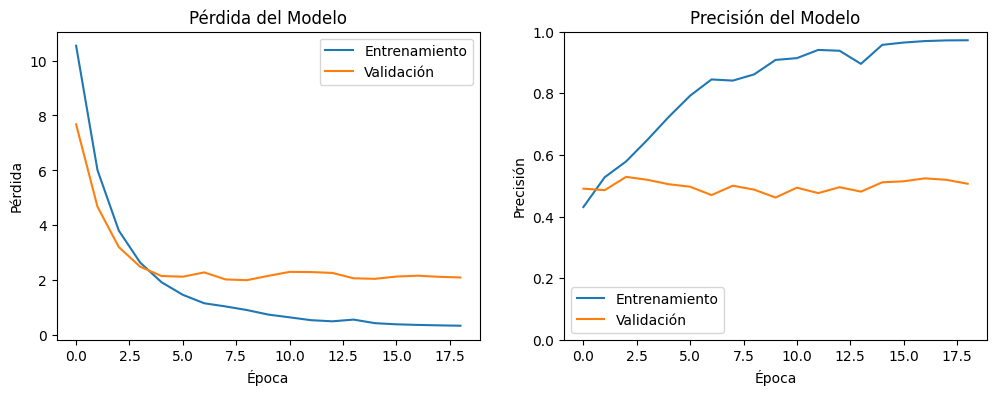

In [39]:
# Gráfica de pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
#plt.ylim(0, 2)  # Ajusta estos valores según sea necesario
plt.legend()



plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()

plt.show()

In [24]:
# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/DeepLearning/modelo_resnet50.h5')

In [25]:
# Guardar el modelo en el nuevo formato nativo de Keras
model.save('/content/drive/MyDrive/DeepLearning/modelo_resnet50.keras')